In [22]:
!pip install skfuzzy

     ---------------------------------------- 2.1/2.1 MB 3.9 MB/s eta 0:00:00
     ---------------------------------------- 82.8/82.8 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.1.3
    Uninstalling click-8.1.3:
      Successfully uninstalled click-8.1.3


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import sklearn
from sklearn.datasets import make_blobs

Generating Random Clusters for Testing

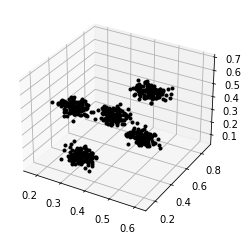

In [75]:
# Wrapper function for SKLearn MakeBlobs
def generateRandomFit(size, models, std = 0.05, center = (0.1, 0.9), n = 5):
    # Random state = 1 for reproducibility
    X, y = make_blobs(n_samples=size, cluster_std=std, center_box=center, centers=n, n_features=models, random_state=1)
    return X, y

X, y = generateRandomFit(671, 3)

ax = plt.axes(projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2], '.k')

In [81]:
def plotClusters(X, labs, ncenters, ax):
    # Wraps a plotting function to return different colored clusters in a 3D axis
    colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
    ax = plt.axes(projection='3d')
    for j in range(ncenters):
        ax.plot(X[labs == j, 0], X[labs == j, 1], X[labs==j, 1], '.', color=colors[j])
    return ax
        
def fuzzyCluster(data, ncenters, m=2, stop=0.005, maxiter=1000):
    # Wraps Fuzzy Cluster function, only outputting percent belongs and formal cluster.
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, ncenters, m, error=stop, maxiter=maxiter, init=None)
    label = np.argmax(u, axis=0)
    return u, label, fpc

def howManyClusters(X, mintest=2,maxtest=15):
    # Determines how many clusters should be used using the Fuzzy Partitions Coefficient (FPC)
    # https://scikit-fuzzy.github.io/scikit-fuzzy/auto_examples/plot_cmeans.html#example-plot-cmeans-py
    fpcs = []
    listtests = np.arange(mintest,maxtest)
    for ncenters in listtests:
        _, _, fpc = fuzzyCluster(X, ncenters)
        fpcs.append(fpc)
    plt.plot(listtests, fpcs)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Fuzzy Partition Coefficient (FPC)")
    return listtests[np.argmax(fpcs)]

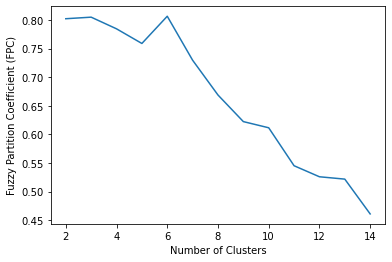

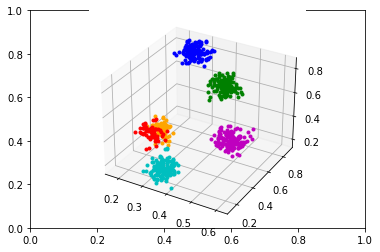

In [87]:
n_clusters = howManyClusters(X)
fig, ax = plt.subplots()    
_, labels, _ = fuzzyCluster(X, n_clusters)
ax = plotClusters(X, labels, n_clusters, ax)